This file will run an LSTM model to predict the electricity prices. 

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from functions import plot_comparison, evaluate_lstm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [2]:
df = pd.read_csv('../../Data/zra_sgp_dam.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Defining Functions

In [3]:
def encode_cyclic(df, col, max_val):
    """"
    Time features like Hour, Month, day_of_week are cyclical, not linear. 
    Without encoding them properly, the model will misunderstand their relationships.
    """
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

def preprocess(df):
    df = df.copy()
    
    # Cyclic encode time features
    df = encode_cyclic(df, 'Hour', 24)
    df = encode_cyclic(df, 'Month', 12)
    df = encode_cyclic(df, 'day_of_week', 7)
    
    # Drop unused or problematic columns
    df = df.drop(columns=['Hour', 'Month', 'day_of_week'])  # Keep cyclic versions instead
    
    # Fill/clean if needed
    df = df.fillna(method='ffill').dropna()
    
    return df

In [4]:
# Create sequence for LSTM adapted for WT
def create_sequences_wt(data, target_col, lookback=48, forecast_horizon=24):
    X, y = [], []
    for i in range(len(data) - lookback - forecast_horizon):
        X_seq = data.iloc[i:i + lookback].values  # Use the lookback period for X
        y_seq = data.iloc[i + lookback:i + lookback + forecast_horizon][target_col].values  # Multi-target for y
        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)


In [5]:
# Dataset and DataLoader
class PriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [6]:
import torch
import torch.nn as nn

class WT_LSTMForecast(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2,
                 forecast_horizon=24, output_dim=4):  # output_dim corresponds to number of coefficients you're forecasting
        super().__init__()
        self.forecast_horizon = forecast_horizon
        self.output_dim = output_dim

        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # [batch, seq_len, hidden_size]
        lstm_out = lstm_out[:, -self.forecast_horizon:, :]  # Slicing to get the last 'forecast_horizon' time steps
        out = self.fc(lstm_out)  # [batch, forecast_horizon, output_dim]
        return out


In [7]:
import torch
import torch.nn as nn

class LogCoshLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        loss = torch.log(torch.cosh(y_pred - y_true + 1e-12))  # added epsilon to prevent log(0)
        return torch.mean(loss)


In [8]:
import copy
import torch

def train_model(model, dataloader, val_dataloader=None, epochs=10, lr=1e-3, patience=10, min_delta=1e-4):
    device = next(model.parameters()).device
    criterion = LogCoshLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')
    best_model_state = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)

        if val_dataloader:
            model.eval()
            val_total_loss = 0
            with torch.no_grad():
                for xb, yb in val_dataloader:
                    xb, yb = xb.to(device), yb.to(device)
                    pred = model(xb)
                    loss = criterion(pred, yb)
                    val_total_loss += loss.item()

            avg_val_loss = val_total_loss / len(val_dataloader)
            val_loss_history.append(avg_val_loss)

            if best_val_loss - avg_val_loss > min_delta:
                best_val_loss = avg_val_loss
                best_model_state = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break
        else:
            print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    if val_dataloader:
        model.load_state_dict(best_model_state)

    return loss_history, val_loss_history if val_dataloader else loss_history


In [9]:
def plot_loss(loss_history):
    plt.figure(figsize=(10, 4))
    plt.plot(loss_history, label='Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss per Epoch')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [10]:
def plot_shap_importance(importances, feature_names=None):
    import matplotlib.pyplot as plt
    import numpy as np

    indices = np.argsort(importances)[::-1]
    names = list(feature_names) if feature_names is not None else [f"Feature {i}" for i in range(len(importances))]

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [names[i] for i in indices], rotation=45, ha='right')
    plt.title("SHAP Feature Importance (Averaged)")
    plt.tight_layout()
    plt.show()


In [11]:
def predict_from_datetime(model, df, timestamp, n_steps=48, target_col='Price (USD/MWh)', scaler_y=None):
    """
    Predict 24-hour prices starting from a given timestamp.

    Args:
        model: Trained LSTMForecast model.
        df: Preprocessed + scaled DataFrame (with DateTime index).
        timestamp: Datetime string or pd.Timestamp (e.g. '2023-01-01 00:00').
        n_steps: Number of past hours to use (default = 48).
        target_col: Name of target column.
        scaler_y: Scaler used for the target column.

    Returns:
        List of (datetime, predicted_price) tuples.
    """
    if isinstance(timestamp, str):
        timestamp = pd.Timestamp(timestamp)
        
    # Check if enough history is available
    start_idx = df.index.get_loc(timestamp)
    if start_idx < n_steps:
        raise ValueError("Not enough history before this timestamp.")

    # Build the input sequence (excluding target columns)
    seq_df = df.iloc[start_idx - n_steps:start_idx].drop(columns=[target_col, 'target_scaled'])
    seq_input = seq_df.values  # shape: (n_steps, num_features)

    # Predict the future prices
    model.eval()
    with torch.no_grad():
        x = torch.tensor(seq_input[np.newaxis, :, :], dtype=torch.float32)
        y_pred = model(x).squeeze().numpy()  # shape: (forecast_horizon, )

    # Reverse scaling (if provided)
    if scaler_y is not None:
        y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))  # Inverse transform predictions
        y_pred_original_flat = y_pred_original.flatten()  # Flatten to 1D
    else:
        y_pred_original_flat = y_pred  # If no scaler, use raw predictions

    # Build future timestamps
    future_times = [timestamp + pd.Timedelta(hours=i) for i in range(24)]
    
    return list(zip(future_times, y_pred_original_flat))


# Training model

In [96]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Preprocess (make sure 'Date' becomes index)
df_clean = preprocess(df)

# Define target
target_col = 'Price (USD/MWh)'
features = df_clean.drop(columns=[target_col])
target = df_clean[target_col]

# Columns by type
minmax_cols = ['Tati- normalised output', 'E_Grid (Mw)', 'Revenues (USD)', 
               'Flow_chavuma', 'Level_kariba', 'Flow_nana']
standard_cols = ['Volatility_1 Day', 'Volatility_3 Days', 'Volatility_7 Days', 'Volatility_30 Days',
                 'roc_49h', 'momentum_49h']
no_scaling_cols = ['Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos',
                   'day_of_week_sin', 'day_of_week_cos']

# Initialize scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
scaler_y = MinMaxScaler()

# Copy clean DataFrame
df_scaled = df_clean.copy()

# Apply scalers to appropriate columns
df_scaled[minmax_cols] = minmax_scaler.fit_transform(df_clean[minmax_cols])
df_scaled[standard_cols] = standard_scaler.fit_transform(df_clean[standard_cols])

# Target scaling (fit only on the column, keep shape)
df_scaled["target_scaled"] = scaler_y.fit_transform(df_clean[[target_col]])

# Optionally retain unscaled target for reference
df_scaled[target_col] = target


/var/folders/t_/0kjgy0zn0k10thg9kn806w140000gn/T/ipykernel_33497/4031471906.py:22: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



# Applying WT

In [97]:
import pywt

# ---- Step 1: Extract normalized target as numpy array ----
target_array = df_scaled["target_scaled"].values

# ---- Step 2: Apply single-level Wavelet Decomposition ----
# --- Parameters ---
wavelet = 'db1'       # You can experiment with other wavelets
level = 3             # Number of decomposition levels

# --- Apply Multi-Level DWT ---
coeffs = pywt.wavedec(target_array, wavelet=wavelet, level=level)

# Denoising (optional)
threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(target_array)))
denoised_coeffs = [coeffs[0]]  # Approximation stays unchanged
for cd in coeffs[1:]:
    denoised_cd = pywt.threshold(cd, threshold, mode='soft')
    denoised_coeffs.append(denoised_cd)

# --- Reconstruct signal (optional step, useful for visualization) ---
signal_denoised = pywt.waverec(denoised_coeffs, wavelet=wavelet)

# --- Format features ---
def pad_or_truncate(arr, target_len):
    if len(arr) < target_len:
        return np.pad(arr, (0, target_len - len(arr)), mode='constant')
    else:
        return arr[:target_len]

min_len = min(len(c) for c in coeffs)
features_wt = np.column_stack([pad_or_truncate(c, min_len) for c in coeffs])
feature_names = [f'cA_{level}'] + [f'cD_{i}' for i in range(level, 0, -1)]
df_wt = pd.DataFrame(features_wt, columns=feature_names)

# Downsample explanatory features to match min_len
features_only = df_scaled.drop(columns=[target_col, "target_scaled"]).values
factor = len(features_only) // min_len
features_downsampled = features_only[:factor * min_len].reshape(min_len, factor, features_only.shape[1]).mean(axis=1)

# Combine downsampled features with WT features
df_lstm_input = pd.DataFrame(
    np.hstack([features_downsampled, df_wt.values]),
    columns=[*df_scaled.drop(columns=[target_col, "target_scaled"]).columns, *feature_names]
)

# Inspect final input
print("LSTM input shape:", df_lstm_input.shape)
df_lstm_input.head()


LSTM input shape: (8766, 37)


,Tati- normalised output,E_Grid (Mw),Revenues (USD),Volatility_1 Day,Volatility_3 Days,Volatility_7 Days,Volatility_30 Days,Flow_chavuma,Level_kariba,Flow_nana,...,Hour_sin,Hour_cos,Month_sin,Month_cos,day_of_week_sin,day_of_week_cos,cA_3,cD_3,cD_2,cD_1
0,0.121125,0.121125,0.009766,-1.603109,-1.903265,-1.982205,-2.07914,0.305269,0.180531,0.065688,...,0.657975,0.504882,0.5,0.866025,-0.781831,0.62349,0.223092,0.001892,0.000312,0.000318
1,0.596008,0.596008,0.052648,-1.603109,-1.903265,-1.982205,-2.07914,0.305269,0.180531,0.065688,...,0.108253,-0.822265,0.5,0.866025,-0.781831,0.62349,0.229695,0.003951,0.006562,-0.000018
2,0.030277,0.030277,0.002924,-1.592212,-1.903265,-1.982205,-2.07914,0.305269,0.180531,0.065688,...,-0.766229,0.317382,0.5,0.866025,-0.781831,0.62349,0.252190,0.007725,-0.000088,-0.003094
3,0.160270,0.160270,0.013787,-1.516439,-1.903265,-1.982205,-2.07914,0.313858,0.179646,0.066620,...,0.657975,0.504882,0.5,0.866025,0.000000,1.00000,0.225399,-0.000292,0.005550,-0.000141
4,0.981445,0.981445,0.090532,-1.518805,-1.903265,-1.982205,-2.07914,0.313858,0.179646,0.066620,...,0.108253,-0.822265,0.5,0.866025,0.000000,1.00000,0.243642,-0.001564,-0.006938,-0.000053


In [ ]:
forecast_horizon = 24
lookback = 24 * 7 # 7 days of lookback

# Create sequences for each WT coefficient
X, y_cA = create_sequences_wt(df_lstm_input, target_col='cA_3', lookback=lookback, forecast_horizon=forecast_horizon)
_, y_d3 = create_sequences_wt(df_lstm_input, target_col='cD_3', lookback=lookback, forecast_horizon=forecast_horizon)
_, y_d2 = create_sequences_wt(df_lstm_input, target_col='cD_2', lookback=lookback, forecast_horizon=forecast_horizon)
_, y_d1 = create_sequences_wt(df_lstm_input, target_col='cD_1', lookback=lookback, forecast_horizon=forecast_horizon)

# Stack all coefficients into final target
y = np.stack([y_cA, y_d3, y_d2, y_d1], axis=-1)  # shape: (samples, forecast_horizon, 4)# Train-validation-test split (70-15-15 split)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Create datasets
train_ds = PriceDataset(X_train, y_train)
val_ds = PriceDataset(X_val, y_val)
test_ds = PriceDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=False, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)

In [99]:
import numpy as np
from random import uniform
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

# Assuming LSTMForecast and train_ds are defined elsewhere
# Also assuming val_loader is defined somewhere

input_size = X.shape[2]  # Number of features (should match the input size of the LSTM)

class WOA:
    def __init__(self, n_whales, max_iter, bounds):
        self.n_whales = n_whales
        self.max_iter = max_iter
        self.bounds = bounds
        self.population = self.init_population()
        self.best_whale = None
        self.best_fitness = float('inf')

    def init_population(self):
        """Initialize whale population randomly within the specified bounds."""
        population = []
        for _ in range(self.n_whales):
            whale = [uniform(*self.bounds[param]) for param in self.bounds]
            population.append(whale)
        return population

    def smape(self, y_true, y_pred):
        """Symmetric Mean Absolute Percentage Error"""
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
        smape = np.mean(np.abs(y_pred - y_true) / denominator) * 100
        return smape
    
    def evaluate_model(self, model, val_loader, device):
        """Evaluate the model on the validation set."""
        model.to(device)  # Ensure model is on the correct device (GPU or CPU)
        model.eval()  # Set the model to evaluation mode
        y_true = []
        y_pred = []

        with torch.no_grad():  # No gradient calculation needed during evaluation
            for xb, yb in val_loader:  # Iterate over validation data
                xb, yb = xb.to(device), yb.to(device)  # Move data to the correct device
                output = model(xb)  # Model's predictions

                y_true.append(yb.cpu().numpy())  # Store actual values
                y_pred.append(output.cpu().numpy())  # Store predicted values

        # Flatten the lists into 1D arrays for easy SMAPE calculation
        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)

        return y_true, y_pred

    def fitness(self, whale):
        """Calculate fitness (SMAPE) of the current whale configuration."""
        hidden_size, num_layers, dropout, lr = whale

        N_subset = 8760 - lookback
        subset_indices = list(range(N_subset))
        subset_train_ds = torch.utils.data.Subset(train_ds, subset_indices)
        subset_train_loader = DataLoader(subset_train_ds, batch_size=64, shuffle=True)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        model = WT_LSTMForecast(
            input_size=input_size,
            hidden_size=int(hidden_size),
            num_layers=int(num_layers),
            dropout=dropout,
            output_dim=4
        ).to(device)  # Move the model to the correct device

        # Get actuals and predictions from validation
        y_true, y_pred = self.evaluate_model(model, val_loader, device)

        return self.smape(y_true, y_pred)


    def update_position(self, whale, a, best_whale):
        """Update the position of the whale based on the hunting behavior."""
        A = 2 * a * np.random.rand() - a  # Randomization for exploration
        C = 2 * np.random.rand()  # Another randomization factor for exploration
        p = np.random.rand()  # Probability for exploitation or exploration

        if p < 0.5:
            if np.abs(A) >= 1:
                # Exploration: Random movement
                rand_whale = self.population[np.random.randint(self.n_whales)]
                new_whale = np.array(rand_whale) - A * np.abs(C * np.array(rand_whale) - np.array(whale))
            else:
                # Exploitation: Move towards best whale
                new_whale = np.array(best_whale) - A * np.abs(C * np.array(best_whale) - np.array(whale))
        else:
            distance_best = np.abs(np.array(best_whale) - np.array(whale))
            new_whale = distance_best * np.exp(a * distance_best) * np.cos(2 * np.pi * np.random.rand())

        # Bound check: Ensure the new whale is within bounds
        new_whale = np.clip(new_whale, [self.bounds[param][0] for param in self.bounds],
                            [self.bounds[param][1] for param in self.bounds])
        
        return new_whale

    def optimize(self, smape_threshold=10.0):
        """Run the Whale Optimization Algorithm."""
        for t in tqdm(range(self.max_iter), desc="WOA Iterations"):
            a = 2 - t * (2 / self.max_iter)

            for i in tqdm(range(self.n_whales), desc=f"Whales (Iteration {t+1})", leave=False):
                whale = self.population[i]
                hidden_size, num_layers, dropout, lr = whale

                # print(f"Iteration {t+1}, Whale {i+1}: hidden_size={int(hidden_size)}, "
                #       f"num_layers={int(num_layers)}, dropout={dropout:.3f}, lr={lr:.6f}")

                fitness_val = self.fitness(whale)

                if fitness_val < self.best_fitness:
                    self.best_fitness = fitness_val
                    self.best_whale = whale

                    # Early stopping if precision threshold met
                    if self.best_fitness <= smape_threshold:
                        # print(f"\nStopping early at iteration {t+1} with SMAPE {self.best_fitness:.2f}")
                        return self.best_whale, self.best_fitness

                self.population[i] = self.update_position(whale, a, self.best_whale)

        return self.best_whale, self.best_fitness

In [100]:

# Define the bounds for the hyperparameters
bounds = {
    'hidden_size': (32, 256),  # Increased hidden size range to 256
    'num_layers': (1, 4),      # Increased num_layers range to 4
    'dropout': (0.1, 0.5),     # Increased dropout range to 0.5
    'lr': (5e-4, 1e-2)         # Increased learning rate range to 1e-2
}

# Create the WOA optimizer with the updated bounds
woa = WOA(n_whales=10, max_iter=50, bounds=bounds)
# Run optimization
best_params, best_val_loss = woa.optimize()

# Output the best found parameters and corresponding validation loss
print("\nBest configuration from WOA:")
print(f"Best Params: {best_params}")
print(f"Best Validation Loss: {best_val_loss}")

WOA Iterations:   0%|          | 0/50 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [101]:
best_params = [2.56000000e+02, 1.51423982e+00, 1.51423982e-01, 2.85523587e-03]

⏹️ Early stopping at epoch 29

Training completed in 385.13 seconds.


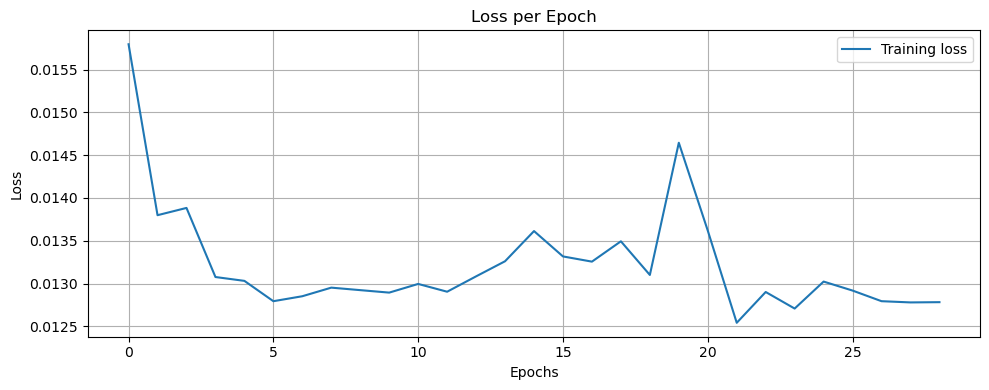

In [102]:
"Train model with best params from WOA"
import time  # Add this at the top of your script if not already imported
# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = X.shape[2]  # Number of features (should match the input size of the LSTM)

model = WT_LSTMForecast(
    input_size=input_size,
    hidden_size=int(best_params[0]),  # Ensure integer value for hidden_size
    num_layers=int(best_params[1]),   # Ensure integer value for num_layers
    dropout=best_params[2]
).to(device)

# Train the model with timing
start_time = time.time()

train_losses, val_losses = train_model(
    model,
    dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=100,
    lr=best_params[3],
    patience=15,       # stop if no val improvement
    min_delta=1e-4     # must improve by at least this much
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining completed in {elapsed_time:.2f} seconds.")

plot_loss(train_losses)


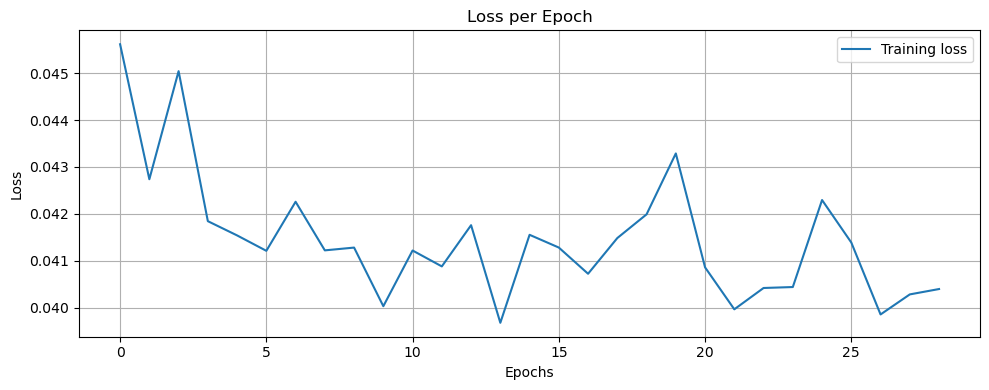

In [103]:
plot_loss(val_losses)

# Model Evaluation 

In [104]:
# Switch model to eval mode
model.eval()

def get_predictions(model, dataloader):
    all_preds = []
    with torch.no_grad():
        for xb, _ in dataloader:
            xb = xb.to(device)
            preds = model(xb)
            all_preds.append(preds.cpu().numpy())
    return np.concatenate(all_preds, axis=0)

# Get predictions from validation and test loaders
val_pred_np = get_predictions(model, val_loader)  # <-- Now this is defined
test_pred_np = get_predictions(model, test_loader)

In [105]:
def reconstruct_from_coeffs(y_pred, wavelet='db1'):
    """
    Reconstruct time series from predicted DWT coefficients.
    y_pred: numpy array of shape (samples, forecast_horizon, 4)
    Returns:
        reconstructed: numpy array of shape (samples, forecast_horizon)
    """
    reconstructed = []
    for sample in y_pred:
        # sample: (forecast_horizon, 4)
        sample_recon = []
        for t in range(sample.shape[0]):
            cA3, cD3, cD2, cD1 = sample[t]

            # Use pywt.waverec to reconstruct from multi-level coeffs
            coeffs = [np.array([cA3]), np.array([cD3]), np.array([cD2]), np.array([cD1])]
            signal = pywt.waverec(coeffs, wavelet)

            # Take only the first value (or mean) to align with time step t
            sample_recon.append(signal[0])  # or signal.mean(), etc.

        reconstructed.append(sample_recon)

    return np.array(reconstructed)


In [106]:
reconstructed = reconstruct_from_coeffs(val_pred_np)
reconstructed = scaler_y.inverse_transform(reconstructed)

In [107]:
y_val.shape

(1286, 24, 4)

In [108]:
true_val = reconstruct_from_coeffs(y_val)
true_test = reconstruct_from_coeffs(y_test)

true_val = scaler_y.inverse_transform(true_val)
true_test = scaler_y.inverse_transform(true_test)

y_val_flat = true_val.flatten()
y_test_flat = true_test.flatten()

In [109]:
reconstructed_val = reconstruct_from_coeffs(val_pred_np)
reconstructed_val = scaler_y.inverse_transform(reconstructed_val)

reconstructed_test = reconstruct_from_coeffs(test_pred_np)
reconstructed_test = scaler_y.inverse_transform(reconstructed_test)


In [110]:
recon_val_flat = reconstructed_val.flatten()
recon_test_flat = reconstructed_test.flatten()


In [111]:
# import numpy as np

# def flatten_predictions(coeffs):
#     """Flatten the predictions to 1D if needed."""
#     return coeffs.reshape(-1)  # Flatten 2D to 1D if it's not already

# # Switch model to eval mode
# model.eval()

# def get_predictions(model, dataloader):
#     all_preds = []
#     with torch.no_grad():
#         for xb, _ in dataloader:
#             xb = xb.to(device)
#             preds = model(xb)
#             all_preds.append(preds.cpu().numpy())
#     return np.concatenate(all_preds, axis=0)

# # Get predictions from validation and test loaders
# val_pred_np = get_predictions(model, val_loader)  # <-- Now this is defined
# test_pred_np = get_predictions(model, test_loader)


# # ---- Step 2: Split into components (4 coefficients) ----
# val_cA3, val_cD3, val_cD2, val_cD1 = val_pred_np[:, :, 0], val_pred_np[:, :, 1], val_pred_np[:, :, 2], val_pred_np[:, :, 3]
# test_cA3, test_cD3, test_cD2, test_cD1 = test_pred_np[:, :, 0], test_pred_np[:, :, 1], test_pred_np[:, :, 2], test_pred_np[:, :, 3]

# # Flatten all coefficients
# val_cA3_flat = flatten_predictions(val_cA3)
# val_cD3_flat = flatten_predictions(val_cD3)
# val_cD2_flat = flatten_predictions(val_cD2)
# val_cD1_flat = flatten_predictions(val_cD1)

# test_cA3_flat = flatten_predictions(test_cA3)
# test_cD3_flat = flatten_predictions(test_cD3)
# test_cD2_flat = flatten_predictions(test_cD2)
# test_cD1_flat = flatten_predictions(test_cD1)

# # Print shapes of flattened coefficients for debugging
# print(f"Flattened val_cA3 shape: {val_cA3_flat.shape}")
# print(f"Flattened val_cD3 shape: {val_cD3_flat.shape}")
# print(f"Flattened val_cD2 shape: {val_cD2_flat.shape}")
# print(f"Flattened val_cD1 shape: {val_cD1_flat.shape}")


In [112]:
# print("Shapes of validation coefficients:")
# print("val_cA3:", val_cA3.shape)
# print("val_cD3:", val_cD3.shape)
# print("val_cD2:", val_cD2.shape)
# print("val_cD1:", val_cD1.shape)

# print("\nShapes of test coefficients:")
# print("test_cA3:", test_cA3.shape)
# print("test_cD3:", test_cD3.shape)
# print("test_cD2:", test_cD2.shape)
# print("test_cD1:", test_cD1.shape)


In [113]:
# import numpy as np
# import pandas as pd
# import pywt

# def reconstruct_signal(cA3, cD3, cD2, cD1, wavelet='db1'):
#     coeffs = [cA3, cD3, cD2, cD1]
#     signal = pywt.waverec(coeffs, wavelet)
#     return signal

# # Assuming val_pred_np and test_pred_np shapes: (samples, forecast_horizon, 4)

# # Step 1: Split coefficients
# val_cA3, val_cD3, val_cD2, val_cD1 = val_pred_np[:, :, 0], val_pred_np[:, :, 1], val_pred_np[:, :, 2], val_pred_np[:, :, 3]
# test_cA3, test_cD3, test_cD2, test_cD1 = test_pred_np[:, :, 0], test_pred_np[:, :, 1], test_pred_np[:, :, 2], test_pred_np[:, :, 3]

# # Step 2: Reconstruct each sample forecast horizon signal
# val_reconstructed = [reconstruct_signal(val_cA3[i], val_cD3[i], val_cD2[i], val_cD1[i]) for i in range(val_cA3.shape[0])]


# test_reconstructed = []
# for i in range(test_cA3.shape[0]):
#     recon_signal = reconstruct_signal(
#         test_cA3[i], test_cD3[i], test_cD2[i], test_cD1[i]
#     )
#     test_reconstructed.append(recon_signal)

# # Convert to numpy arrays
# val_reconstructed = np.array(val_reconstructed)
# test_reconstructed = np.array(test_reconstructed)

# # Optional: flatten if you want 1D arrays of all reconstructed values
# val_recon_flat = val_reconstructed.flatten()
# test_recon_flat = test_reconstructed.flatten()

# # Step 3: Create DataFrames aligned with val/test datetime indices
# # Assuming you have val_index_expanded and test_index_expanded from earlier

# val_df_reconstructed = pd.DataFrame({
#     'reconstructed_signal': val_recon_flat
# }, index=val_index_expanded[:len(val_recon_flat)])

# test_df_reconstructed = pd.DataFrame({
#     'reconstructed_signal': test_recon_flat
# }, index=test_index_expanded[:len(test_recon_flat)])


In [114]:
# # Assuming y_val, y_test shape: (samples, forecast_horizon, 4)
# # Flatten only over samples and forecast_horizon (keep coeff dimension for inverse transform if needed)

# samples_val, fh_val, n_coeff = y_val.shape
# samples_test, fh_test, _ = y_test.shape

# # Flatten to 2D for inverse scaling: (samples * forecast_horizon, coeffs)
# y_val_2d = y_val.reshape(samples_val * fh_val, n_coeff)
# y_test_2d = y_test.reshape(samples_test * fh_test, n_coeff)

# # Inverse transform (assuming scaler_y is fitted for shape (n_coeff,))
# y_val_original_2d = scaler_y.inverse_transform(y_val_2d)
# y_test_original_2d = scaler_y.inverse_transform(y_test_2d)

# # Now flatten to 1D if needed, or keep 2D for further processing
# # Here for datetime indexing, total forecast points:
# val_length = samples_val * fh_val
# test_length = samples_test * fh_test

# # Your original datetime index for the full dataset
# start_date = df.index.min()
# end_date = df.index.max()
# all_datetimes = pd.date_range(start=start_date, end=end_date, freq='h')
# N_total = len(all_datetimes)

# # Compute split indices
# train_size = int(0.7 * N_total)
# val_size = int(0.15 * N_total)
# val_start = train_size
# test_start = train_size + val_size

# # Generate datetime indexes for your predictions — match total forecast points, not multiplied by coeffs
# val_index_expanded = pd.date_range(start=all_datetimes[val_start], periods=val_length, freq='h')
# test_index_expanded = pd.date_range(start=all_datetimes[test_start], periods=test_length, freq='h')

# # Create DataFrames or Series indexed by these for evaluation or plotting
# val_df = pd.DataFrame(y_val_original_2d, index=val_index_expanded, columns=[f'coeff_{i}' for i in range(n_coeff)])
# test_df = pd.DataFrame(y_test_original_2d, index=test_index_expanded, columns=[f'coeff_{i}' for i in range(n_coeff)])


In [115]:
val_df

,coeff_0,coeff_1,coeff_2,coeff_3
2022-08-08 09:00:00,384.268368,71.045003,16.710235,1.413174
2022-08-08 10:00:00,254.061576,10.573190,1.002403,-0.268672
2022-08-08 11:00:00,88.877222,-4.662278,1.437746,-0.208581
2022-08-08 12:00:00,96.058727,3.739530,-0.613439,19.156470
2022-08-08 13:00:00,80.281618,-0.893178,-0.104773,-12.994377
...,...,...,...,...
2026-02-15 04:00:00,410.710099,85.921456,-0.369771,0.145144
2026-02-15 05:00:00,561.324655,95.592903,-0.313932,2.335385
2026-02-15 06:00:00,201.045247,-119.030948,-6.025599,-0.657459
2026-02-15 07:00:00,245.474277,67.804491,5.631421,0.467911


In [116]:
# Create datetime index from original DataFrame
start_date = df.index.min()
end_date = df.index.max()
all_datetimes = pd.date_range(start=start_date, end=end_date, freq='h')
N_total = len(all_datetimes)

# Recalculate split indices
train_size = int(0.7 * N_total)
val_size = int(0.15 * N_total)
val_start = train_size
val_end = train_size + val_size
test_start = val_end

In [117]:
# Generate datetime index for predictions
val_index_expanded = pd.date_range(start=all_datetimes[val_start], periods=len(y_val_flat), freq='h')
test_index_expanded = pd.date_range(start=all_datetimes[test_start], periods=len(y_test_flat), freq='h')

# Create DataFrames for evaluation
X_val_df = pd.DataFrame(index=val_index_expanded)
X_test_df = pd.DataFrame(index=test_index_expanded)


In [118]:
X_val_df

""
2022-08-08 09:00:00
2022-08-08 10:00:00
2022-08-08 11:00:00
2022-08-08 12:00:00
2022-08-08 13:00:00
...
2026-02-14 04:00:00
2026-02-14 05:00:00
2026-02-14 06:00:00
2026-02-14 07:00:00


In [119]:
import plotly.graph_objects as go

def plot_predictions(
    y_true, y_pred, df_index,
    start_time="2023-08-01 00:00:00",
    n_hours=500,
    error_threshold=15
):
    # Convert inputs
    start_time = pd.to_datetime(start_time)

    # Build aligned DataFrame
    df = pd.DataFrame({
        'actual': y_true,
        'predicted': y_pred
    }, index=pd.to_datetime(df_index))

    # Slice the time range
    df_slice = df.loc[start_time : start_time + pd.Timedelta(hours=n_hours)]

    # Calculate error
    df_slice['error'] = abs(df_slice['actual'] - df_slice['predicted'])

    # Identify high error regions
    high_error_mask = df_slice['error'] > error_threshold

    # Create Plotly figure
    fig = go.Figure()

    # Actual values (Deep blue)
    fig.add_trace(go.Scatter(
        x=df_slice.index, y=df_slice['actual'],
        mode='lines', name='True',
        line=dict(color='#1f77b4', width=2)
    ))

    # Predicted values (Soft green)
    fig.add_trace(go.Scatter(
        x=df_slice.index, y=df_slice['predicted'],
        mode='lines', name='Predicted',
        line=dict(color='#2ca02c', width=2)
    ))

    # High-error markers (Bold red)
    if high_error_mask.any():
        fig.add_trace(go.Scatter(
            x=df_slice.index[high_error_mask],
            y=df_slice['predicted'][high_error_mask],
            mode='markers',
            marker=dict(size=6, color='#d62728', symbol='circle'),
            name=f'Error > {error_threshold}',
            text=[f"Error: {e:.2f}" for e in df_slice['error'][high_error_mask]],  # Hover text
            hoverinfo='text+x+y',
            showlegend=True
        ))

    # Layout styling
    fig.update_layout(
        title=f"LSTM Forecast from {start_time.strftime('%Y-%m-%d %H:%M')} ({n_hours} hours)",
        xaxis_title="Time",
        yaxis_title="Value",
        template="plotly_white",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        height=500,
        margin=dict(l=40, r=40, t=60, b=40)
    )

    fig.show()

In [120]:
plot_predictions(
    y_true=y_val_flat,
    y_pred=recon_val_flat,  # Use the reconstructed, inverse-scaled prediction
    df_index=X_val_df.index,  # Assuming you have this aligned with y_val
    start_time="2023-08-01 00:00:00",
    n_hours=500
)


/var/folders/t_/0kjgy0zn0k10thg9kn806w140000gn/T/ipykernel_33497/2804165366.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [121]:
# --- Evaluate model with reconstructed predictions ---
results = evaluate_lstm(
    y_val=y_val_flat,
    y_val_pred=recon_val_flat,       # updated
    y_test=y_test_flat,
    y_test_pred=recon_test_flat,     # updated
    X_val=X_val_df,
    X_test=X_test_df
)

print(results)


           Metric        MAE        DAE        RMSE        R2  \
0  Validation Set  64.772881  31.610669   84.522011 -0.037369   
1        Test Set  80.004360  71.211264  111.136843 -0.485553   

   Lower Predictions (%)  
0              44.657206  
1              74.083787  


In [122]:
print("recon_val_flat:", recon_val_flat.shape)
print("y_val_flat:", y_val_flat.shape)

recon_val_flat: (30864,)
y_val_flat: (30864,)


In [123]:
def predict_from_datetime(model, df, timestamp, n_steps=48, target_col='Price (USD/MWh)', scaler_y=None):
    """
    Predict 24-hour prices starting from a given timestamp.

    Args:
        model: Trained LSTMForecast model.
        df: Preprocessed + scaled DataFrame (with DateTime index).
        timestamp: Datetime string or pd.Timestamp (e.g. '2023-01-01 00:00').
        n_steps: Number of past hours to use (default = 48).
        target_col: Name of target column.
        scaler_y: Scaler used for the target column.

    Returns:
        List of (datetime, predicted_price) tuples.
    """
    if isinstance(timestamp, str):
        timestamp = pd.Timestamp(timestamp)
        
    # Check if enough history is available
    start_idx = df.index.get_loc(timestamp)
    if start_idx < n_steps:
        raise ValueError("Not enough history before this timestamp.")

    # Build the input sequence (excluding target columns)
    seq_df = df.iloc[start_idx - n_steps:start_idx].drop(columns=[target_col, 'target_scaled'])
    seq_input = seq_df.values  # shape: (n_steps, num_features)

    # Predict the future prices
    model.eval()
    with torch.no_grad():
        x = torch.tensor(seq_input[np.newaxis, :, :], dtype=torch.float32)
        y_pred = model(x).squeeze().numpy()  # shape: (forecast_horizon, )

    # Reverse scaling (if provided)
    if scaler_y is not None:
        y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))  # Inverse transform predictions
        y_pred_original_flat = y_pred_original.flatten()  # Flatten to 1D
    else:
        y_pred_original_flat = y_pred  # If no scaler, use raw predictions

    # Build future timestamps
    future_times = [timestamp + pd.Timedelta(hours=i) for i in range(24)]
    
    return list(zip(future_times, y_pred_original_flat))


In [124]:
preds = predict_from_datetime(model, df_scaled, '2024-01-01 00:00',scaler_y=scaler_y)

for t, price in preds:
    print(f"{t}: ${price:.2f}")

RuntimeError: input.size(-1) must be equal to input_size. Expected 37, got 33

#  Post-Hoc Interpretability with Integrated Gradients (XAI)
To understand how the LSTM model arrives at its predictions, we apply post-hoc interpretability methods—techniques used after model training to explain behavior without altering the model itself. One such method is Integrated Gradients, which attributes importance scores to input features based on their contribution to a specific prediction. This approach is particularly valuable for complex, black-box models like LSTMs, where internal mechanisms are not easily interpretable. By applying Integrated Gradients, we gain insights into both individual decisions (local interpretation) and broader model behavior (global interpretation), helping to build transparency, trust, and accountability in the forecasting process.


## Local Interpretation
The local interpretation using Integrated Gradients provides insight into which input features most influenced the model’s prediction for a specific timestamp. By attributing importance values to each feature in that one sample, we can understand the direction (positive or negative) and magnitude of their impact on the predicted price. This helps explain the model's reasoning at an individual decision level — for example, highlighting that high 7-day volatility or weekend timing pushed the forecast upward in that particular context.

In [ ]:
from captum.attr import IntegratedGradients
import torch
import matplotlib.pyplot as plt

# Ensure model is in eval mode
model.eval()

# Extract feature names from your DataFrame
feature_names = features.columns.tolist()  # must match order in X_val

# Select a sample
sample_idx = 0 # sample_idx is simply the index of a single sample (row) in your validation dataset (X_val)
input_tensor = torch.tensor(X_val[sample_idx:sample_idx+1], dtype=torch.float32, requires_grad=True)

# Initialize Integrated Gradients
ig = IntegratedGradients(model)

# Compute attributions for the first output (e.g., first forecasted hour)
attributions, delta = ig.attribute(
    input_tensor, target=0, return_convergence_delta=True
)

# Sum attributions across the time dimension
attributions_sum = attributions.sum(dim=1).squeeze().detach().numpy()

# Plot feature attributions with proper labels
plt.figure(figsize=(12, 6))
plt.bar(feature_names, attributions_sum)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Attribution")
plt.title("Local Feature Attributions using Integrated Gradients")
plt.tight_layout()
plt.show()

The global interpretation aggregates feature attributions across many samples to show which inputs the model relies on most consistently. By averaging importance scores, it highlights the overall influence of each feature on predictions—revealing patterns such as persistent reliance on long-term volatility or cyclical time features. This offers a high-level understanding of the model’s behavior and helps validate that it aligns with domain knowledge.

In [ ]:
all_attributions = []
model.eval()

for i in range(len(X_val)):
    input_tensor = torch.tensor(X_val[i:i+1], dtype=torch.float32, requires_grad=True)
    attributions, _ = ig.attribute(input_tensor, target=0, return_convergence_delta=True)
    summed = attributions.sum(dim=1).squeeze().detach().numpy()
    all_attributions.append(summed)

# Now average across all samples
avg_attr = np.mean(np.stack(all_attributions), axis=0)

# Plot global feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_names, avg_attr)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Attribution")
plt.title("Global Feature Importance via Integrated Gradients")
plt.tight_layout()
plt.show()

